## Overview

This Jupyter notebook is dedicated to feature selection using the Random Forest model. We utilize preprocessed data from the "Rainfall_prediction.ipynb" notebook. The goal is to predict next-day rain by training two classification models, namely Random Forest and Logistic Regression, on the target variable `RainTomorrow`.

## Dataset Information

The dataset used in this analysis contains approximately 10 years of daily weather observations from various locations across Australia, obtained from https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package and covers a comprehensive range of weather observations.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score , jaccard_score , f1_score , log_loss , confusion_matrix, classification_report
import sklearn.metrics as metrics

In [3]:
df = pd.read_csv('Preprocessed_Data.csv')
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,1,0
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,1,0
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
#Features and Target variable
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
print(f"X shape: {X.shape}, y shape: {y.shape}")

#Splitting the Dataset for Training and Testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

#Distribution of the target variable
value_counts = df['RainTomorrow'].value_counts()
percentage_counts = df['RainTomorrow'].value_counts(normalize=True) * 100
print("\nClass Distribution:")
print(pd.DataFrame({'Counts': value_counts, 'Percentage': percentage_counts}))

X shape: (142193, 113), y shape: (142193,)
X_train shape: (113754, 113), y_train shape: (113754,)
X_test shape: (28439, 113), y_test shape: (28439,)

Class Distribution:
   Counts  Percentage
0  110316   77.581878
1   31877   22.418122


In [5]:
#Apply oversampling to the minority class using Synthetic Minority Over-sampling Technique (SMOTE)

print("Before oversampling:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("y_train",Counter(y_train))

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\nAfter oversampling:")
print(f"X_resampled shape: {X_train.shape}, y_resampled shape: {y_train.shape}")
print("y_resampled",Counter(y_train))

Before oversampling:
X_train shape: (113754, 113), y_train shape: (113754,)
y_train Counter({0: 88218, 1: 25536})



After oversampling:
X_resampled shape: (176436, 113), y_resampled shape: (176436,)
y_resampled Counter({0: 88218, 1: 88218})


## Feature selection 

In [6]:
#Feature selection with Random Forest
rf_feature_selector = RandomForestClassifier(random_state=42)
rf_feature_selector.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_feature_selector.feature_importances_

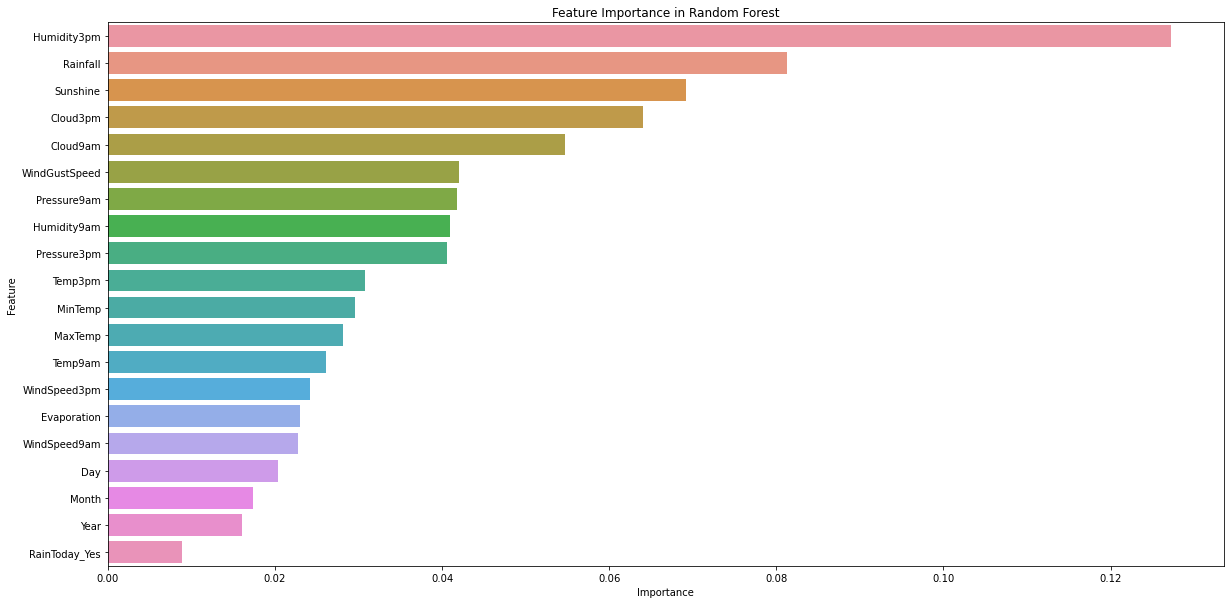

In [8]:
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features
top_n = 20  
top_features_df = feature_importance_df.head(top_n)
selected_features = top_features_df['Feature']

plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=top_features_df)
plt.title('Feature Importance in Random Forest')
plt.show()

In [9]:
#Subset data with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## Random Forest Model

In [11]:
#Grid Search for Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_params = grid_search.best_params_
print('best hyperparameters:\n')
print(best_params)

best hyperparameters:

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Training Accuracy: 0.8599265456029381
Testing Accuracy: 0.8155350047470024
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88     22098
           1       0.57      0.67      0.62      6341

    accuracy                           0.82     28439
   macro avg       0.74      0.76      0.75     28439
weighted avg       0.83      0.82      0.82     28439



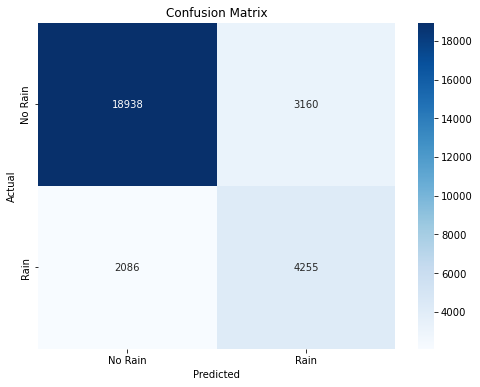

In [13]:
# Model Training
model = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

# Model Evaluation
y_train_pred = model.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)

conf_matrix = confusion_matrix(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Classification Report:\n", classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Logistic Regression Model

Training Accuracy: 0.7939366115758689
Testing Accuracy: 0.7872639684939695
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     22098
           1       0.52      0.74      0.61      6341

    accuracy                           0.79     28439
   macro avg       0.72      0.77      0.73     28439
weighted avg       0.83      0.79      0.80     28439



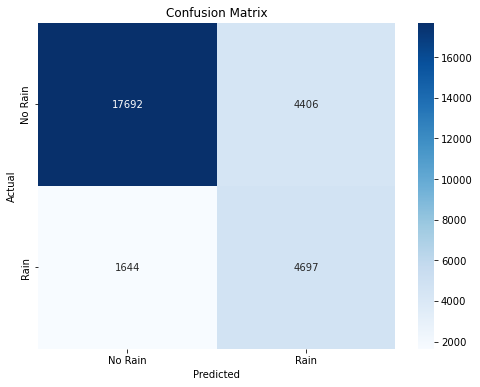

In [14]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Model Training
model = LogisticRegression(C=1, solver='lbfgs',max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Model Evaluation
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

conf_matrix = confusion_matrix(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Classification Report:\n", classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1. Using Logistic Regression in "Rainfall_prediction.ipynb", we obtained the training accuracy of 0.89 and testing accuracy of 0.83. Precision for class 0 (no rain) is high, while precision for class 1 (rain) is relatively lower. The model tends to be better at correctly identifying instances with no rain (class 0) than instances with rain (class 1). Here, using Random Forest for feature selection and then utilizing Logistic regression for classification, we obtained the training accuracy of 0.79 and testing accuracy of 0.79. Precision for class 0 is still relatively high, but precision for class 1 has improved compared to logistic regression alone. The model with feature selection seems to perform better on instances with rain (class 1) compared to logistic regression alone.

2. Utilizing Random Forest Classification with Random Forest Feature Selection result in the training accuracy of 0.86 and testing accuracy of 0.82. Both precision for class 0 and class 1 are relatively balanced. The random forest model, when used for both feature selection and classification, achieves a good balance between correctly identifying instances with no rain (class 0) and instances with rain (class 1).
Conclusion:

3. Using Random Forest for feature selection seems to have a positive impact on the performance of both Logistic Regression and Random Forest models.
The Random Forest model, when used for both feature selection and classification, performs well in terms of overall accuracy and balanced precision for both classes.